# Examining variability in soccer referee behavior

Author: Nathan Sanford (nathansanford2013@u.northwestern.edu)

Last updated: 5/6/2020

Description: Code used for my soccer referee clustering project

This project uses English Premier League game data to assess the variability in referee performance. We'll attempt to determine if there are distinct modes or styles of referee performance by examining their per-game statistics. The sources for the game data are discussed in the ReadMe.

In [1]:
import pandas as pd

EPL = pd.read_csv('EPL_matchData_2014_15_to_2018_19.csv')
EPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1900 non-null   object 
 1   HomeTeam  1900 non-null   object 
 2   AwayTeam  1900 non-null   object 
 3   FTHG      1900 non-null   int64  
 4   FTAG      1900 non-null   int64  
 5   FTR       1900 non-null   object 
 6   Referee   1900 non-null   object 
 7   HS        1900 non-null   int64  
 8   AS        1900 non-null   int64  
 9   HST       1900 non-null   int64  
 10  AST       1900 non-null   int64  
 11  HF        1900 non-null   int64  
 12  AF        1900 non-null   int64  
 13  HC        1900 non-null   int64  
 14  AC        1900 non-null   int64  
 15  HY        1900 non-null   int64  
 16  AY        1900 non-null   int64  
 17  HR        1900 non-null   int64  
 18  AR        1900 non-null   int64  
 19  Reds      1900 non-null   int64  
 20  Fouls     1900 non-null   int6

This dataset contains 5 years worth of game-level data (1900 games) with lots of statistics about each game. We want to examine referee behavior so lets extract the stuff that referees control directly: fouls, cards, and penalties. We'll take this data and group it by referee.

# Assemble referee dataset from game data
First lets see how many referees we have in this time period, and drop the referees who didn't referee very many games. 

Text(0, 0.5, 'Seasons refereed')

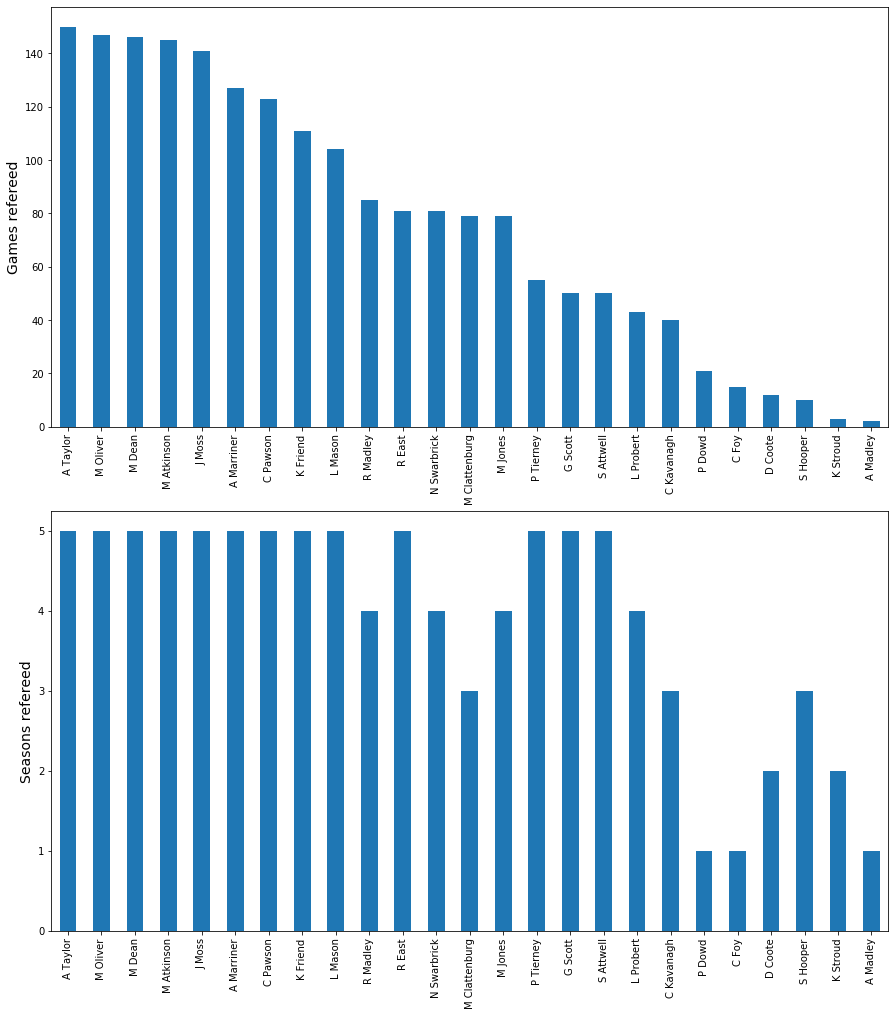

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2,1,figsize=(15,17))

ref_game_counts=EPL["Referee"].value_counts()
ref_game_counts.plot(ax=axes[0],kind='bar')
axes[0].set_ylabel('Games refereed',fontsize=14)

dates = EPL['Date'].str.split('/')
years = list(d[2] for d in dates)
months = list(d[0] for d in dates)

seasons = ['']*1900
for m,y,i in zip(months,years,range(len(months))):
    if int(m)<8:
        y=str(int(y)-1)
    seasons[i]=y+'-'+str(int(y)-1999)

EPL.insert(0,'Season',seasons)  
refT=EPL.groupby(['Referee']).Season.unique()
refSeasons = pd.Series((len(r) for r in refT),index=refT.index,name='NumSeasons')

refSeasons[ref_game_counts.index].plot(ax=axes[1],kind='bar')
axes[1].set_ylabel('Seasons refereed',fontsize=14)   

There are 25 referees in this period. I'll drop all referees who refereed less than 40 games. This leaves us with 19 referees in our sample who each refereed in at least 3 seasons in our time period.

In [3]:
EPL=EPL[EPL["Referee"].isin(list(ref_game_counts[ref_game_counts>=40].index))]

In [4]:
# compile referee aggregate statistics (a little opaque without the codebook)
refs = pd.DataFrame({'Name':EPL['Referee'].value_counts().sort_index().index.to_list(),
                     'Games':EPL['Referee'].value_counts().sort_index().values})
refs['Home_WinPct'] = EPL[EPL['FTR']=='H']["Referee"].value_counts().sort_index().values/refs['Games']  
refs['Away_WinPct'] = EPL[EPL['FTR']=='A']["Referee"].value_counts().sort_index().values/refs['Games']
refs['Home_Fouls'] = EPL.groupby('Referee').HF.mean().values
refs['Away_Fouls'] = EPL.groupby('Referee').AF.mean().values
refs['Home_Yellows'] = EPL.groupby('Referee').HY.mean().values
refs['Away_Yellows'] = EPL.groupby('Referee').AY.mean().values
refs['Home_Reds'] = EPL.groupby('Referee').HR.mean().values
refs['Away_Reds'] = EPL.groupby('Referee').AR.mean().values
refs['Home_Pens'] = EPL.groupby('Referee').HPMa.mean().values + EPL.groupby('Referee').HPMi.mean().values
refs['Away_Pens'] = EPL.groupby('Referee').APMa.mean().values + EPL.groupby('Referee').APMi.mean().values

refs.to_csv('RefTotals_split.csv',index=False)

This refs dataset now has the relevant per game referee statistics (split up by home team and away team). I'll leave potential inquiries into issues of home/away bias to further projects and just look at the combined statistics for each referee.

In [5]:
refTots = pd.DataFrame({'Name':refs['Name'],'Fouls':refs['Home_Fouls']+refs['Away_Fouls'],
                  'Yellows':refs['Home_Yellows']+refs['Away_Yellows'],
                  'Reds':refs['Home_Reds']+refs['Away_Reds'],
                  'Pens':refs['Home_Pens']+refs['Away_Pens']})
refTots.to_csv('RefTotals.csv',index=False)

# Explore referee data

Now let's visualize the data by means of a pairplot. This mix of scatterplots and histograms can help indicate collinearities and patterns in a high-dimensional dataset.

<Figure size 432x288 with 0 Axes>

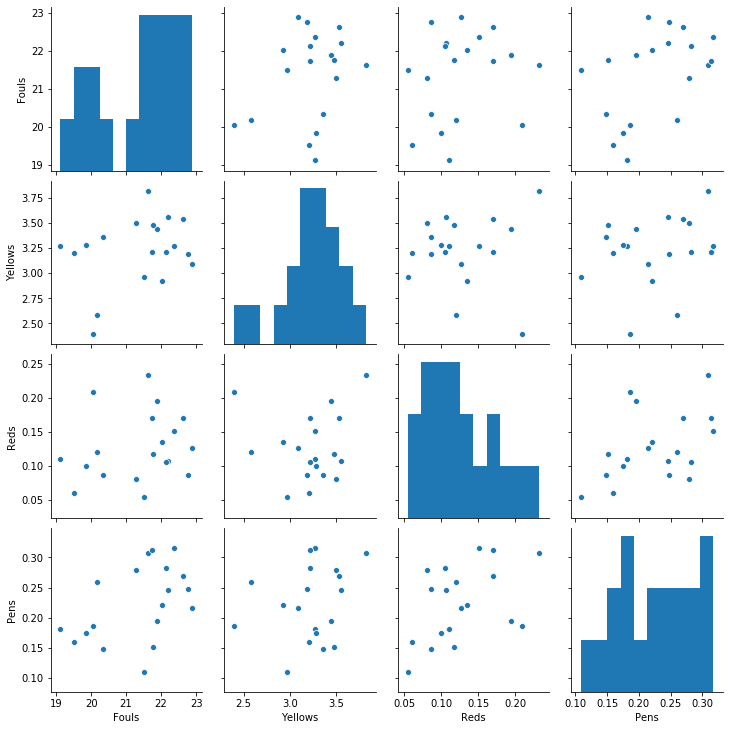

The correlation between fouls and yellow cards is 0.303965
The correlation between fouls and red cards is 0.200169
The correlation between fouls and penalties is 0.459921
The correlation between yellow and red cards is 0.060704
The correlation between yellow cards and penalties is 0.239838
The correlation between red cards and penalties is 0.450584


In [6]:
import seaborn as sns
import numpy as np

plt.figure()
sns.pairplot(refTots)
plt.show()
Cors = np.corrcoef(refTots.iloc[:,1:],rowvar=False)
print('The correlation between fouls and yellow cards is {0:7.6f}'.format(Cors[0,1]))
print('The correlation between fouls and red cards is {0:7.6f}'.format(Cors[0,2]))
print('The correlation between fouls and penalties is {0:7.6f}'.format(Cors[0,3]))
print('The correlation between yellow and red cards is {0:7.6f}'.format(Cors[1,2]))
print('The correlation between yellow cards and penalties is {0:7.6f}'.format(Cors[1,3]))
print('The correlation between red cards and penalties is {0:7.6f}'.format(Cors[2,3]))

There don't appear to be any obviously strong collinearities or relationships between the variables. This is actually a little surprising to me as I expected yellow and red cards to be correlated as oftentimes a player picks up a red card by getting two yellow cards over the course of a game. However, I don't see that in the data so I'll keep the four variables. Also, note here that my goal is simply to mine the data, not predict penalties using the other variables, so I don't mind that there may be weak to moderate collinearities between the variables.

# Begin clustering analysis

Now, let's attempt to break the referees up into clusters using scikit learn. The first thing we'll do is normalize the data using the preprocessing module. This is especially important as the fouls are orders of magnitude larger than the other features.  

In [7]:
from sklearn import preprocessing
train = preprocessing.scale(refTots.iloc[:,1:],axis=0,
                            with_mean=True, with_std=True,copy=True)

We'll use a hierarchical clustering algorithm, as our data does not contain very many observations (only 19 referees in our sample). This algorithm works by successively splitting the data into clusters and can be implemented via the sklearn agglomerative clustering module (https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering).

It can be useful to visually examine this process via a dendogram, which plots a tree of the clusters as they are formed through successive splitting procedures. I used code from [this sklearn example page](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py) to plot the dendogram.

In [8]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

## this function taken from sklearn example webpage linked above

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

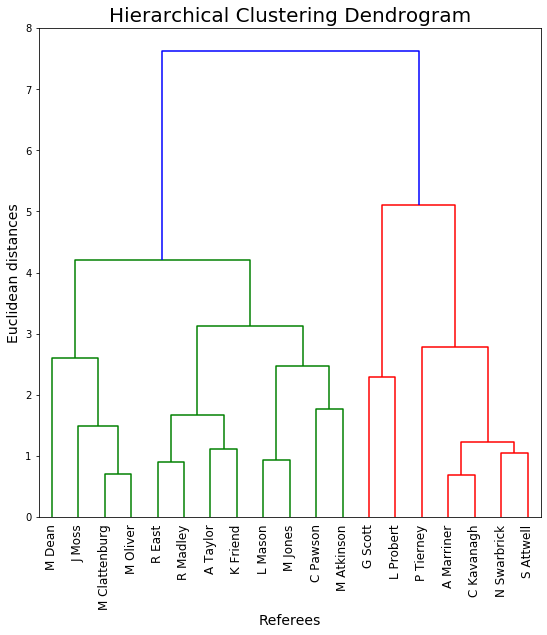

In [9]:
hierarchical = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity = 'euclidean', linkage ='ward')

model = hierarchical.fit(train)
plt.figure(figsize=(9,9))
plt.title('Hierarchical Clustering Dendrogram',fontsize=20)
# plot the levels of the dendrogram
plot_dendrogram(model, leaf_rotation=90, leaf_font_size=12,
                labels = refTots.Name.values)
plt.xlabel("Referees",fontsize=14)
plt.ylabel('Euclidean distances',fontsize=14)
plt.show()

The dendogram gives an imprecise sense of the degree of separation between the different referees. For instance, we can surmise that Mike Dean and Stuart Atwell (far left and far right) are dissimilar, but we need to do something more rigorous. For this, let's perform a silhouette analysis as this allows for a visual analysis of how many clusters exist within a dataset. The [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) is a measure between -1 and +1 of clustered data that assessesses how similar an object is to its own cluster compared to other clusters (separation). A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters, while a negative value is evidence that a sample has been misclassified as it is more similar to another cluster than its own.

For our purposes, we'll be breaking the data into different numbers of clusters and then compute silhouette scores for each sample. Then, we can plot the silhouette score for each sample using an adapted version of the code from this [scikit learn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py).

For num. clusters = 2 The average silhouette_score is : 0.33963194583077244
For num. clusters = 3 The average silhouette_score is : 0.375080947477188
For num. clusters = 4 The average silhouette_score is : 0.2930768357791768
For num. clusters = 5 The average silhouette_score is : 0.28718241805578804


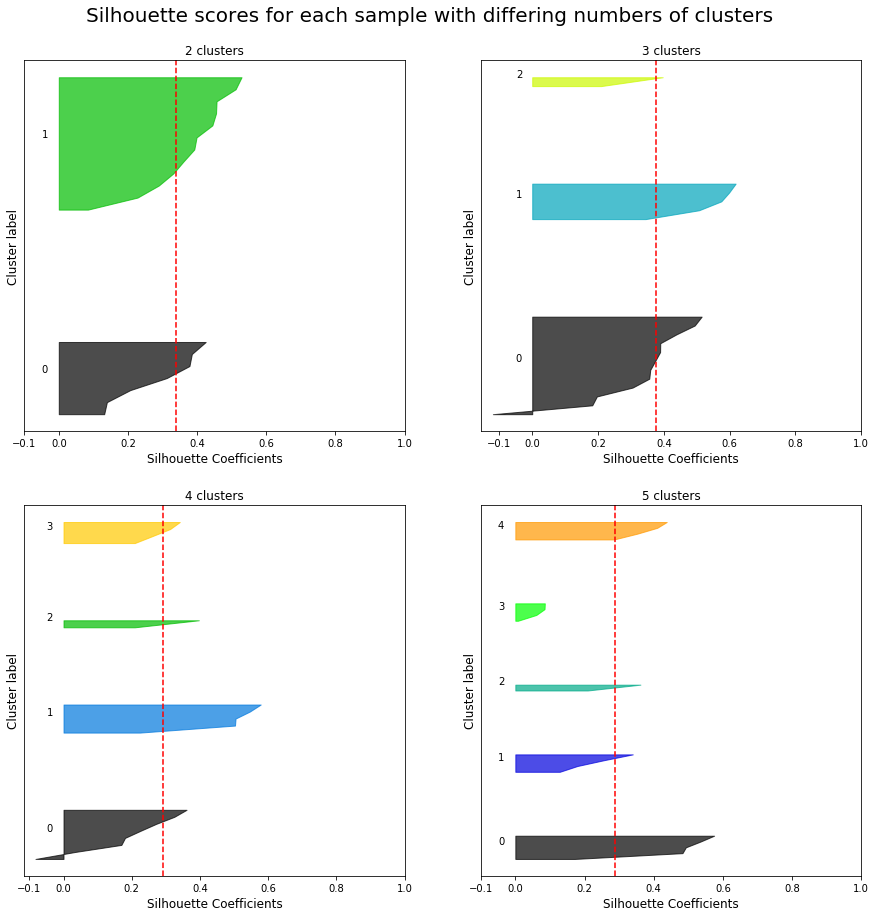

In [10]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

max_num_c = 5
sil_avg = np.zeros(max_num_c-1)
fig, ax = plt.subplots(2, 2,figsize=(15,15))
for num_c in range(2, max_num_c+1):
    row = int(np.floor(num_c/2)-1)
    col = np.mod(num_c,2)
    clst = AgglomerativeClustering(n_clusters = num_c)
    mod = clst.fit(train)
    labels = mod.labels_
    sil_avg[num_c-2] = silhouette_score(train,labels)
    print("For num. clusters =", num_c,
          "The average silhouette_score is :", sil_avg[num_c-2])
    sample_sil_vals = silhouette_samples(train, labels)    
    ax[row][col].set_title('{} clusters'.format(num_c))
    
    y_lower = 10
    for i in range(num_c):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_sil_vals[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num_c)
        ax[row][col].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax[row][col].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax[row][col].set_xlabel("Silhouette Coefficients",fontsize=12)
    ax[row][col].set_ylabel("Cluster label",fontsize=12)

    # The vertical line for average silhouette score of all the values
    ax[row][col].axvline(x=sil_avg[num_c-2], color="red", linestyle="--")

    ax[row][col].set_yticks([])  # Clear the yaxis labels / ticks
    ax[row][col].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    fig.suptitle('Silhouette scores for each sample with differing numbers of clusters',
                 y=0.93,fontsize=20)

In each plot, the red dashed line is the average silhouette scores for all samples. The samples from each cluster are arrayed on the left with the silhouette coefficients displayed as a horizontal bar chart. This gives a sense of the size of each cluster and how internally coherent each cluster is. We see for the 5 cluster plot that cluster label 3 is much more dissimilar than the other clusters, indicating that the clustering was suboptimal. Additionally, the three and four cluster plots have a sample with a negative score indicating that it was misclassified, another problematic indication for the clustering. 

For these reasons, and the fact that some clusters are very small in these simulations (as small as one or two samples), we determine that there are 2 clusters. Now, let's investigate these two clusters. We'll rerun the clustering and examine the mean values for each feature in the clusters.

In [11]:
num_c=2
model = AgglomerativeClustering(n_clusters=num_c)
labels = model.fit_predict(train)
refTots['Label'] = labels

## Examine cluster attributes
for i in range(num_c):
    print('\nCluster label {}'.format(i))
    print('This cluster has {} refs in it.'.format(len(refTots[refTots['Label']==i])))
    print(refTots[refTots['Label']==i].mean(axis=0)[:-1])


Cluster label 0
This cluster has 7 refs in it.
Fouls      20.080703
Yellows     3.005675
Reds        0.105786
Pens        0.174198
dtype: float64

Cluster label 1
This cluster has 12 refs in it.
Fouls      22.110854
Yellows     3.349670
Reds        0.139889
Pens        0.253792
dtype: float64


It appears that we've split the referees into two clusters with one that makes less calls of all sorts (less fouls, cards, and penalties) and one that makes more. The differences are particularly stark in the penalties. Let's visualize how the data is split by recreating the pairplot from above where the clusters are presented in different colors.

<Figure size 1080x1080 with 0 Axes>

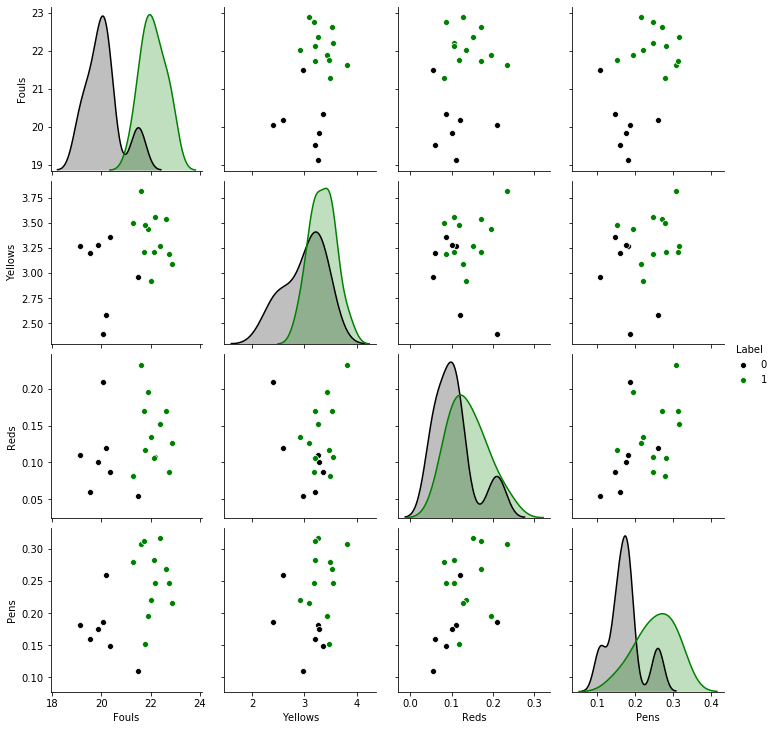

In [12]:
plt.figure(figsize=(15,15))
sns.pairplot(refTots,hue='Label',palette={0:'k',1:'g'})

The clusters are visible in the histograms and the scatterplots. The split in the fouls histogram is particularly striking. While some of the scatterplots (such as the ones involving red cards) show some heterogeneity and mixing of the clusters, the overall picture is clear. Lastly, we'll print out the names of the referees in each cluster.

In [13]:
refTots[refTots['Label']==0].Name.values

array(['A Marriner', 'C Kavanagh', 'G Scott', 'L Probert', 'N Swarbrick',
       'P Tierney', 'S Attwell'], dtype=object)

In [14]:
refTots[refTots['Label']==1].Name.values

array(['A Taylor', 'C Pawson', 'J Moss', 'K Friend', 'L Mason',
       'M Atkinson', 'M Clattenburg', 'M Dean', 'M Jones', 'M Oliver',
       'R East', 'R Madley'], dtype=object)

This prelimary analysis indicates that the variability in referee performance may be significant, and the standardization promised by VAR (see the ReadMe) could be warranted. A number of things could be done to build on this unsupervised analysis, however, such as creating a model to explain the variability in penalties or by employing hypothesis testing or a similar method to assess if the variability in this model is the product of random chance.